100%|██████████| 9.91M/9.91M [00:01<00:00, 5.08MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 133kB/s]
100%|██████████| 1.65M/1.65M [00:01<00:00, 1.27MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 2.24MB/s]


Epoch [1/10]  Train Loss: 0.1566, Train Acc: 0.9525  Val Loss: 0.0760, Val Acc: 0.9757
Epoch [2/10]  Train Loss: 0.0441, Train Acc: 0.9861  Val Loss: 0.0416, Val Acc: 0.9867
Epoch [3/10]  Train Loss: 0.0304, Train Acc: 0.9901  Val Loss: 0.0436, Val Acc: 0.9877
Epoch [4/10]  Train Loss: 0.0234, Train Acc: 0.9922  Val Loss: 0.0377, Val Acc: 0.9882
Epoch [5/10]  Train Loss: 0.0166, Train Acc: 0.9943  Val Loss: 0.0501, Val Acc: 0.9848
Epoch [6/10]  Train Loss: 0.0136, Train Acc: 0.9953  Val Loss: 0.0361, Val Acc: 0.9892
Epoch [7/10]  Train Loss: 0.0111, Train Acc: 0.9961  Val Loss: 0.0447, Val Acc: 0.9890
Epoch [8/10]  Train Loss: 0.0095, Train Acc: 0.9966  Val Loss: 0.0489, Val Acc: 0.9893
Epoch [9/10]  Train Loss: 0.0072, Train Acc: 0.9976  Val Loss: 0.0467, Val Acc: 0.9910
Epoch [10/10]  Train Loss: 0.0075, Train Acc: 0.9972  Val Loss: 0.0513, Val Acc: 0.9868


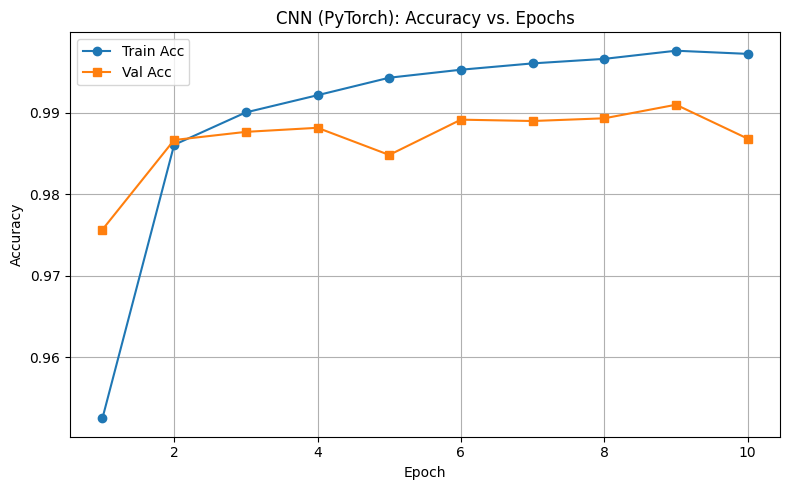

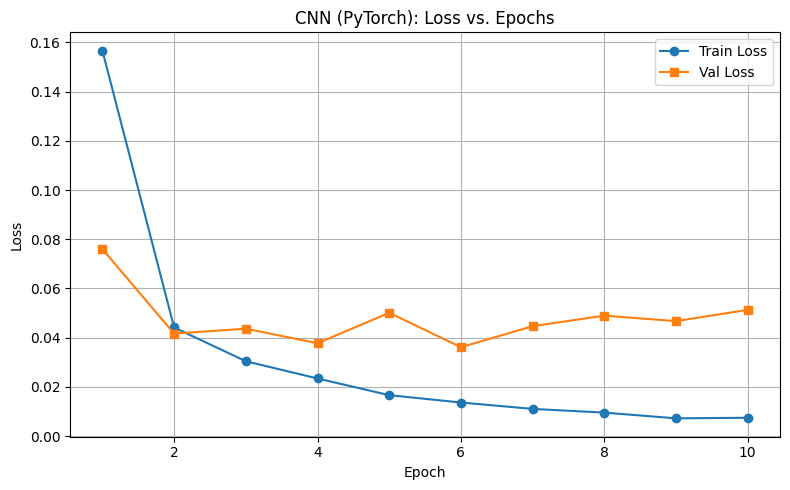

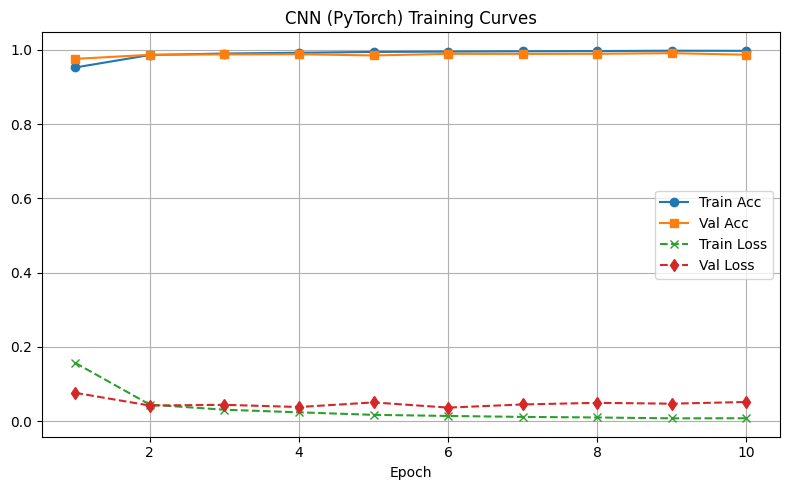

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split
import matplotlib.pyplot as plt

# ----------------------------
# 1) Prepare MNIST DataLoaders
# ----------------------------

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

# Download/train split: 90% train, 10% val
full_train = torchvision.datasets.MNIST(
    root="./data", train=True, download=True, transform=transform
)
train_size = int(0.9 * len(full_train))    # e.g. 54000
val_size   = len(full_train) - train_size  # e.g. 6000
train_ds, val_ds = random_split(full_train, [train_size, val_size])

batch_size = 64
train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True,  num_workers=2)
val_loader   = DataLoader(val_ds,   batch_size=batch_size, shuffle=False, num_workers=2)

# (Optional) If you also want a test set separately:
test_ds    = torchvision.datasets.MNIST(
    root="./data", train=False, download=True, transform=transform
)
test_loader = DataLoader(test_ds, batch_size=batch_size, shuffle=False, num_workers=2)


# ----------------------------
# 2) Define Device & Model
# ----------------------------

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = nn.Sequential(
    nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1),   # input: 1×28×28 → output: 32×28×28
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2, stride=2),                   # 32×14×14
    nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),  # 64×14×14
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2, stride=2),                   # 64×7×7
    nn.Flatten(),                                            # 64*7*7 = 3136
    nn.Linear(64 * 7 * 7, 128),
    nn.ReLU(),
    nn.Linear(128, 10)
).to(device)


# ----------------------------
# 3) Loss & Optimizer
# ----------------------------

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


# ----------------------------
# 4) Training & Validation Loop
# ----------------------------

num_epochs = 10

train_loss_history = []
train_acc_history  = []
val_loss_history   = []
val_acc_history    = []

for epoch in range(1, num_epochs + 1):
    # ---- TRAINING PHASE ----
    model.train()
    running_train_loss = 0.0
    train_correct = 0
    train_total   = 0

    for X_batch, y_batch in train_loader:
        X_batch = X_batch.to(device)               # shape: (N, 1, 28, 28)
        y_batch = y_batch.to(device)               # shape: (N,)

        optimizer.zero_grad()
        outputs = model(X_batch)                   # shape: (N, 10)
        loss = criterion(outputs, y_batch)         # scalar

        loss.backward()
        optimizer.step()

        running_train_loss += loss.item() * X_batch.size(0)
        _, preds = torch.max(outputs, 1)
        train_correct += (preds == y_batch).sum().item()
        train_total   += y_batch.size(0)

    avg_train_loss = running_train_loss / train_total
    train_acc = train_correct / train_total
    train_loss_history.append(avg_train_loss)
    train_acc_history.append(train_acc)

    # ---- VALIDATION PHASE ----
    model.eval()
    running_val_loss = 0.0
    val_correct = 0
    val_total   = 0

    with torch.no_grad():
        for X_val, y_val in val_loader:
            X_val = X_val.to(device)
            y_val = y_val.to(device)

            outputs_val = model(X_val)
            loss_val = criterion(outputs_val, y_val)

            running_val_loss += loss_val.item() * X_val.size(0)
            _, preds_val = torch.max(outputs_val, 1)
            val_correct += (preds_val == y_val).sum().item()
            val_total   += y_val.size(0)

    avg_val_loss = running_val_loss / val_total
    val_acc = val_correct / val_total
    val_loss_history.append(avg_val_loss)
    val_acc_history.append(val_acc)

    print(
        f"Epoch [{epoch}/{num_epochs}]  "
        f"Train Loss: {avg_train_loss:.4f}, Train Acc: {train_acc:.4f}  "
        f"Val Loss: {avg_val_loss:.4f}, Val Acc: {val_acc:.4f}"
    )


# ----------------------------
# 5) Plot & Save Results
# ----------------------------

epochs_range = range(1, num_epochs + 1)

# (a) Accuracy Plot
plt.figure(figsize=(8, 5))
plt.plot(epochs_range, train_acc_history, marker='o', label="Train Acc")
plt.plot(epochs_range, val_acc_history,   marker='s', label="Val Acc")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("CNN (PyTorch): Accuracy vs. Epochs")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("cnn_results_accuracy.png")
plt.show()

# (b) Loss Plot
plt.figure(figsize=(8, 5))
plt.plot(epochs_range, train_loss_history, marker='o', label="Train Loss")
plt.plot(epochs_range, val_loss_history,   marker='s', label="Val Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("CNN (PyTorch): Loss vs. Epochs")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("cnn_results_loss.png")
plt.show()

# (c) Combined Figure (optional)
plt.figure(figsize=(8, 5))
plt.plot(epochs_range, train_acc_history, 'o-', label="Train Acc")
plt.plot(epochs_range, val_acc_history,   's-', label="Val Acc")
plt.plot(epochs_range, train_loss_history, 'x--', label="Train Loss")
plt.plot(epochs_range, val_loss_history,   'd--', label="Val Loss")
plt.xlabel("Epoch")
plt.title("CNN (PyTorch) Training Curves")
plt.legend(loc='best')
plt.grid(True)
plt.tight_layout()
plt.savefig("cnn_results_combined.png")
plt.show()
